# Lensing Tutorial Part 2: Getting to an Unbiased Lensing Spectrum 

## Table of contents:
* [1. Raw lensing spectrum](#lensingspec)
* [2. N0 calculation](#N0)
* [3. N1 calculation](#N1)
* [4. Binning](#binning)
* [5. Other Pairs of Estimators](#estimators)

This notebook walks through the relevant Python classes and functions that calculate the following:

1. Raw lensing spectrum
2. N0 bias
3. N1 bias

It also walks through bits of a master script that collects all the different pieces and spits out the binned bandpowers and lensing amplitudes.

The file that contains the class of power spectrum objects is `lensing/quadest_cl.py`.

I will first be working through the TT estimator lensing spectrum (so a 4-point function TTTT). It is straightforward to generalize to other pairs of estimators. 

## 1. Raw lensing spectrum <a class="anchor" id="lensingspec"></a>

Recall that the lensing map $\phi$ is constructed from a few inputs:
1. $\bar{\phi}$: The quadratic estimator from `qest.eval()` that picks out the correlations at each $L$ from the input lensed CMB maps; this is an inverse-variance weighted $\phi$ field
2. The mean field: the average of many `qest` $\bar{\phi}$
3. The response, $R_L$ : a normalization that enforces the expectation of the phi field averaged over CMB realizations are unbiased ( $\langle \phi \rangle_{CMB} = \phi$ )

The unbiased $\phi$, $\hat{\phi}$ is 

$\hat{\phi}  = \frac{1}{R_L} ( \bar{\phi} - \phi_{MF} ) $


The following functions are all in `lensing/quadest_cl.py`.

1) In forming a naive spectrum, we first take make the 2D spectrum. We multiply $ \bar{\phi} - \phi_{MF} $ with its complex conjugate in `get_sim_qcl()` (or `get_dat_qcl()` for data):

```python
    def get_sim_qcl(self, k1, idx, k2=None):
        """
        Return MapSpectrum2Ds from qeA and qeB for sim number 'idx'
        Note: the mean field is subtracted at this step
        """
        if k2 == None:
            k2 = k1

        qeA_qft = self.qeA.get_sim_qft(k1, idx)
        qeB_qft = self.qeB.get_sim_qft(k2, idx)
        if "None" not in str(type(self.mc_sims_mfA)):
            assert idx not in self.mc_sims_mfA
            # subtract the mean-field correction
            qeA_qft -= self.qeA.get_sim_qft_mf(k1, self.mc_sims_mfA)

        if "None" not in str(type(self.mc_sims_mfB)):
            assert idx not in self.mc_sims_mfB
            # subtract the mean-field correction
            qeB_qft -= self.qeB.get_sim_qft_mf(k2, self.mc_sims_mfB)

        return MapSpectrum2D(
            qeA_qft.parent,
            spec=(qeA_qft * np.conj(qeB_qft)) / self.fcut1234,
        )
```
Here, `MapSpectrum2D()` puts the fft into a map object with number of pixels = (nx, ny) and pixel sizes = (dx, dy).
k1, k2 $\in$ ['Phi_TT', 'Phi_TE', 'Phi_EE', 'Phi_EB', 'Phi_TB']; idx denotes the sim index.


2) We calculate the response 2D spectrum separately, by the call `get_qcr()`:

```python
    def get_qcr(self, k1, k2=None):
        if k2 == None:
            k2 = k1
        return self.qeA.get_response(k1) * self.qeB.get_response(k2)

```
Here `qeA` and `qeB` are `qest` objects from `quadest.py`; the `get_response` function returns the response.


3) We then calculate the 1D spectrum by binning with a $\Delta L = 1$ annulus:

```python
    @utils.cache_pk()
    def get_qcr_lm(self, *args, **kwargs):
        spec = psd_2d_to_1d(
            self.get_qcr(*args, **kwargs), lmax=5000, delta_l=1
        )
        return spec

    @utils.cache_pk()
    def get_dat_qcl_lm(self, *args, **kwargs):
        spec = psd_2d_to_1d(
            self.get_dat_qcl(*args, **kwargs), lmax=5000, delta_l=1
        )
        return spec

    @utils.cache_pk()
    def get_sim_qcl_lm(self, *args, **kwargs):
        spec = psd_2d_to_1d(
            self.get_sim_qcl(*args, **kwargs), lmax=5000, delta_l=1
        )
        return spec
```
`psd_2d_to_1d` sums the power in the $\Delta L = 1$ (dl=1) annulus. 
The 1D spectra are saved as pickle files. They are called later for further manipulation (weights, binning). In this exercise, the 1D spectra are pre-computed, and can be loaded up and plotted.

The N0 and N1 calculations are essentially the same manipulations, but with different input sim maps.

Now let's look at a sim spectra.

In [2]:
%load_ext autoreload
%autoreload 2

# First load the relevant modules
import sys
sys.path.append("/home/yukanakato/spt3g_software/build/")
sys.path.append("/home/yukanakato/spt3g_software/mapspectra/python")
from builtins import zip
import os, sys, scipy, hashlib, glob, subprocess, imp, pdb
import pickle as pk
import healpy as hp
import numpy  as np
import pylab  as pl
import datetime
import glob
from spt3g import lensing as sl
from spt3g import core, maps
from spt3g.lensing import map_spec_utils
from spt3g.mapspectra import basicmaputils, map_analysis, map_spectrum_classes

In [3]:
# Load the parameter file: 
# It defines and loads the obs, cinv, qest, and qecl classes
# We will be using the qecl class; it is defined in relation to obs, cinv, and qest, so we have to load them all
# The sims used are CMB only (no foregrounds), no filtering (these projected maps are not beamed)
par_file = "/home/yukanakato/spt3g_software_tutorial/par_file_tutorial.py"

par = imp.load_source('par',par_file)

---- get cmbs
---- get beams
---- get transfer function
---- data and sims
---- ivfs
---- ivfs:ninv
---- ivfs:sinvfilt
---- ivfs:cinv
---- qest
---- qecl


In [4]:
# Get the qecl class from the parameter file; this is defined with the qest_dd class as input
qecl_dd = par.qecl_len_dd

# Plot sim idx = 161
idx = 161

# Get the 2D qcl, qcr
qecl_2d = qecl_dd.get_sim_qcl('Phi_TT', idx, k2='Phi_TT')
qcr_2d  = qecl_dd.get_qcr('Phi_TT', k2='Phi_TT')

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


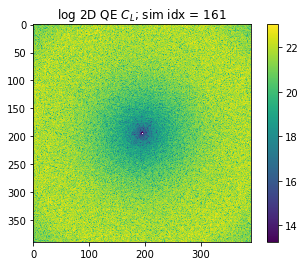

In [5]:
# Plot the 2D qcl 
pl.figure()
pl.imshow(np.real(np.log10(np.fft.fftshift(qecl_2d.get_complex()))), interpolation='None')
pl.title('log 2D QE $C_L$; sim idx = %i'%idx)
pl.colorbar()

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


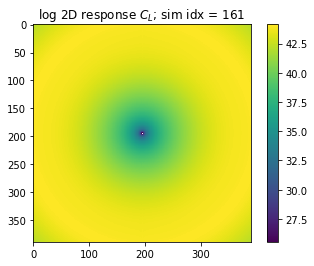

In [6]:
# Plot the 2D qcr
pl.figure()
pl.imshow(np.real(np.log10(np.fft.fftshift(qcr_2d.get_complex()))), interpolation='None')
pl.title('log 2D response $C_L$; sim idx = %i'%idx)
pl.colorbar()

Text(0.5,0,'$L$')

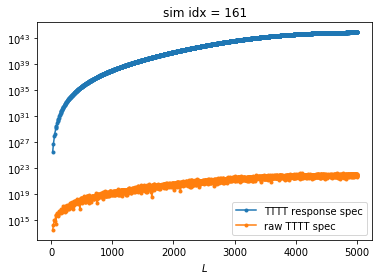

In [7]:
# Get and plot the 1D qcl, qcr
qcl_sim = qecl_dd.get_sim_qcl_lm('Phi_TT', idx, k2='Phi_TT')
qcr_an = qecl_dd.get_qcr_lm('Phi_TT', k2='Phi_TT') # Spectrum of the response

npts = len(qcl_sim.get_cl())
ls = np.arange(npts)

pl.figure()
pl.plot(ls[np.nonzero(np.real(qcr_an))], np.real(qcr_an[np.nonzero(np.real(qcr_an))]), marker='.', ls=None, label='TTTT response spec')
pl.plot(ls[np.nonzero(np.real(qcl_sim))] , np.real(qcl_sim[np.nonzero(np.real(qcl_sim))]), marker='.', ls=None, label='raw TTTT spec')
pl.title('sim idx = %i'%idx)
pl.legend()
pl.yscale('log')
pl.xlabel('$L$')

### Plot the Inverse Variance Filtered Spectrum $\bar{\phi}$

/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)


Text(0.5,0,'$L$')

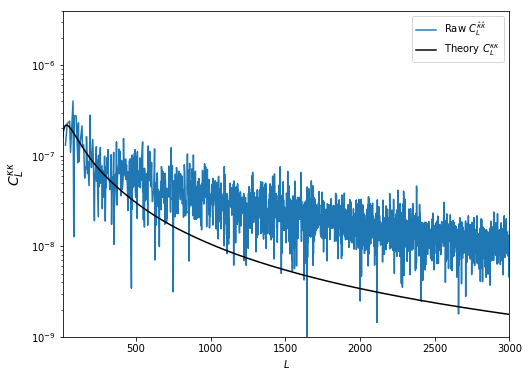

In [8]:
# Now the inverse variance filtered spectrum phi bar
tt_spec_biased_an = np.real(qcl_sim.get_cl())/np.real(qcr_an.get_cl())

# Kappa conversion
t = lambda l: (l*(l+1))**2/4
ell = np.arange(len(tt_spec_biased_an))

pl.figure(figsize=(8,6))
pl.plot(ell[np.nonzero(tt_spec_biased_an)], t(ell)[np.nonzero(tt_spec_biased_an)]*tt_spec_biased_an[np.nonzero(tt_spec_biased_an)], label='Raw $C_L^{\hat{\kappa}\hat{\kappa}}$')
pl.plot(par.cl_unl['L'], t(par.cl_unl['L'])*par.cl_unl['PP'], 'k', label='Theory $C_L^{\kappa\kappa}$')

pl.yscale('log')
pl.xlim([10, 3000])
pl.ylim([1e-9,4e-6])
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.legend()
pl.xlabel('$L$')

You just made a raw lensing spectrum!
The shape and all are about expected. The excess power comes mostly from N0.
The next step is to calculate the N0 and N1 and subtract them from the raw spectrum, but before we do that, let's add the Monte Carlo correction to the response. The response that we've been using is the analytic response only, which doesn't account for the mask.

### MC Response Correction

The response with the Monte Carlo correction is $R^{XY} = R^{XY, Analytic} \times R^{XY, MC}$. See arXiv 1905.05777.

$R^{XY, MC}$ is obtained by first taking the cross spectrum between the input $\phi$ and the intermediate $\phi$ estimate (where the intermediate $\phi$ estimate has been mean field subtracted and normalized by the analytic response). Then, take the average of these cross spectra over simulations, and take the ratio of this average with the input auto spectrum.

The `qecl_len_dk` from the parameter file has all the cross spectra between the input and output $\phi$s. We then use the `get_sim_stats` function to get the average.

In [9]:
tmp_dd = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_dk, par.qecl_len_dd, par.mc_sims_qcr_mc, lbins=np.arange(0,5400+1), k1='Phi_TT')
amp = -1*tmp_dd.avg()[:5000]/par.cl_unl['PP'][:5000]
qcr_mc = np.array(amp**2)

 [00:00:00] accumulating qcl, (k1,k2)=(Phi_TT,Phi_TT) > 03%

/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)


0:00:05] accumulating qcl, (k1,k2)=(Phi_TT,Phi_TT) ---------> 99%

Text(0.5,0,'$L$')

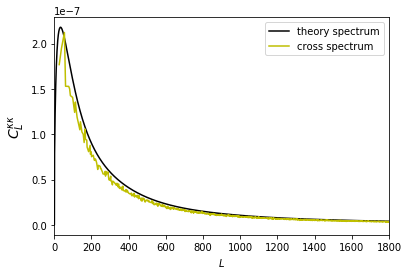

In [10]:
# As a sanity check, plot the average cross spectrum between the input and reconstructed phi
# This is the numerator of the MC response
pl.plot(par.cl_unl['L'], t(par.cl_unl['L'])*par.cl_unl['PP'], 'k', label='theory spectrum')
pl.plot(ell[np.nonzero(tmp_dd.avg()[:5000])], -1*t(ell[np.nonzero(tmp_dd.avg()[:5000])])*tmp_dd.avg()[np.nonzero(tmp_dd.avg()[:5000])], 'y', label='cross spectrum')
pl.xlim(0,1800)
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.legend()
pl.xlabel('$L$')

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


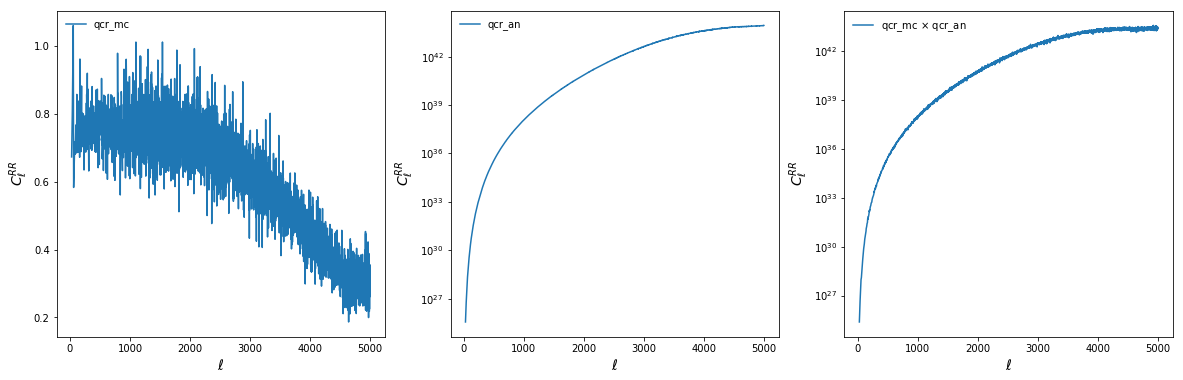

In [11]:
# More sanity checks for the MC response correction - it should be close to 1
qcr_an = qecl_dd.get_qcr_lm('Phi_TT', k2='Phi_TT')

pl.figure(figsize=(20,6))
pl.subplot(131)
pl.plot(ell[np.nonzero(qcr_mc)], qcr_mc[np.nonzero(qcr_mc)], label='qcr_mc')
pl.legend(loc='upper left', labelspacing=0.3)
pl.setp(pl.gca().get_legend().get_frame(), visible=False)
pl.xlabel(r'$\ell$',fontsize=14)
pl.ylabel('$C_\ell^{RR}$', fontsize=14)

pl.subplot(132)
pl.plot(ell[np.nonzero(qcr_an)], qcr_an[np.nonzero(qcr_an)], label='qcr_an')
pl.legend(loc='upper left', labelspacing=0.3)
pl.setp(pl.gca().get_legend().get_frame(), visible=False)
pl.xlabel(r'$\ell$',fontsize=14)
pl.ylabel('$C_\ell^{RR}$', fontsize=14)
pl.yscale('log')

pl.subplot(133)
pl.plot(ell[np.nonzero(qcr_mc*qcr_an)], (qcr_mc*qcr_an)[np.nonzero(qcr_mc*qcr_an)], label=r'qcr_mc $\times$ qcr_an')
pl.legend(loc='upper left', labelspacing=0.3)
pl.setp(pl.gca().get_legend().get_frame(), visible=False)
pl.xlabel(r'$\ell$',fontsize=14)
pl.ylabel('$C_\ell^{RR}$', fontsize=14)
pl.yscale('log')

/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'$L$')

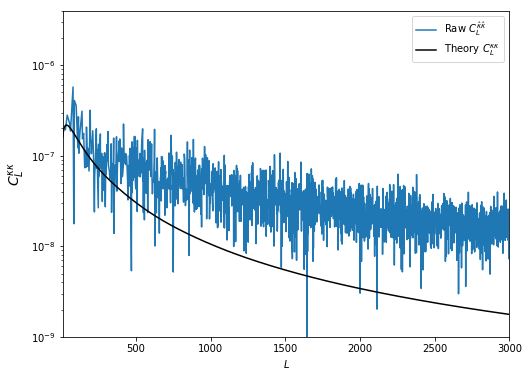

In [12]:
# With this, we can remake the plot from before of the inverse variance filtered raw spectrum compared to theory
# The inverse variance filtered spectrum phi bar with the MC response correction
tt_spec_biased = qcl_sim/(qcr_an*qcr_mc)

# Kappa conversion
t = lambda l: (l*(l+1))**2/4
ell = np.arange(len(tt_spec_biased))

pl.figure(figsize=(8,6))
pl.plot(ell[np.nonzero(tt_spec_biased)], t(ell)[np.nonzero(tt_spec_biased)]*tt_spec_biased[np.nonzero(tt_spec_biased)], label='Raw $C_L^{\hat{\kappa}\hat{\kappa}}$')
pl.plot(par.cl_unl['L'], t(par.cl_unl['L'])*par.cl_unl['PP'], 'k', label='Theory $C_L^{\kappa\kappa}$')

pl.yscale('log')
pl.xlim([10, 3000])
pl.ylim([1e-9,4e-6])
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.legend()
pl.xlabel('$L$')

## 2. N0 calculation  <a class="anchor" id="N0"></a>

The lensing power spectrum is a 4-point function (trispectrum) of the input CMB fields. In there we have the lensing power (primary contraction of the trispectrum), N1 (secondary contraction of the trispectrum), and N0 (disconnected terms).

N0 is non-zero even if the fields are unlensed. It is another way of saying that the trispectrum of 4 Gaussian fields is non-zero. 

The contributions to the N0 include the unlensed CMB and noise in the map. (Foregrounds also contribute to N0. If they were just Gaussian, they would just contribute to N0. But they are a bit more complex, so they can bias the lensing spectrum as well.) 

We get N0 by calculating the following:

$ N_L^{(0)} = \Big \langle 
  C_L^{\hat{\phi}\hat{\phi}}[\bar{U}_{\rm MC}, \bar{V}_{\rm MC'}, \bar{X}_{\rm MC},  \bar{Y}_{\rm MC'}] 
  +C_L^{\hat{\phi}\hat{\phi}}[\bar{U}_{\rm MC}, \bar{V}_{\rm MC'}, \bar{X}_{\rm MC'}, \bar{Y}_{\rm MC}]   \Big \rangle_{{\rm MC,MC'}}$
  
$U, V, X, Y \in [T, E, B]$ denote input CMB maps. MC and MC' denote different simulation realizations. 

To break this down a bit, what we calculate is the raw spectrum from $\phi^{UV}$ and $\phi^{XY}$ where U (X) and V (Y) are from different realizations of the sky. Since U and V are from different realizations, there is no correlated modes generated by lensing. Therefore, power in $\phi^{UV}$ comes from the spurious correlations of the input fields themselves. 

We have two $C_L^{\hat{\phi}\hat{\phi}}$ with two orderings of the sim realizations to account for all the different permutations. 

### Code implementation

Because these are raw spectrum calculations, we can store the qest and qecl objects similarly as the lensing spectrum above. 

In the parameter file, the `qest_dd` and `qecl_dd` contain functions to extract the $\phi$ map and $\phi$ spectrum for the lensing spectrum (for data and sim). For N0, the `qest_ss` and `qecl_ss` are the corresponding classes: the input filtered maps to `qest_ss` are from different realizations.

```python
qest_ss = sl.quadest.QuadEstLib(cl_unl, cl_len, cinv_len,
                                ivfs2=sl.cinv.CinvFiltSim(cinv_len, roll=2),
                                lib_dir=bdir+'par_%s/qest_len_ss/' % qest_prefix)

```
Here `cinv_len` contains the filtered maps. `ivfs2` is an optional argument that denotes the second map input, by default it would be the same as the first map (as is set in `qest_dd`). Here we put in `cinv_len` with the `roll` argument set to 2. So the index of the maps are shifted by 2. Now we have input maps to a $\phi$ estimator that are from different realizations.

The corresponding `qecl_ss` class defined in the parameter file simply takes in `qest_ss`:

```python
qecl_len_ss = sl.quadest_cl.QuadEstCl(qest_ss,
                                      lib_dir=bdir+'par_%s/qecl_len_ss/' % qest_prefix,
                                      mc_sims_mf=None)
```
The argument `mc_sims_mf` tells what range of indices of sims are used for the mean-field subtraction. For N0, there is no mean-field when the realizations of the two legs input to the quadratic estimator is different. The mode-coupling introduced by mask/inhomogeneous noise do not correlate between the two maps. 

To get N0, one basically calculates $C_L^{\hat{\phi}\hat{\phi}}$ with the many sims (e.g. 500).

The code that organizes the summing and averaging of $C_L^{\hat{\phi}\hat{\phi}}$ is in `lensing/spectra_stat.py` (see class `BinnedClStats`).

Below, `sim_stats_ss.avg()` gives the mean of $C_L^{\hat{\phi}\hat{\phi}}$ over the number of sims in `mc_sims_n0`. 

The x2 in `n0_bias` is needed because `qcllib.get_sim_qcl_lm()` returns 1/4 (U1V2X1Y2 + U1V2X2Y1 + U2V1X1Y2 + U2V1U2V1) = 1/2 (U1V2X1Y2 + U1V2X2Y1)
and we need mean of (U1V2X1Y2 + U1V2X2Y1) for n realizations. 

Now, let's calculate N0.

In [13]:
cl_max = 5400
k1 = 'Phi_TT'
k2 = 'Phi_TT'

sim_stats_ss = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_ss, par.qecl_len_dd,
                                                           par.mc_sims_n0,
                                                           lbins=np.arange(0,cl_max+1), qcr_mc=qcr_mc, k1='Phi_TT')

n0_bias = sim_stats_ss.avg() * 2.

 [00:00:00] accumulating qcl, (k1,k2)=(Phi_TT,Phi_TT) > 02%

/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)


0:00:09] accumulating qcl, (k1,k2)=(Phi_TT,Phi_TT) ---------> 99%

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'$L$')

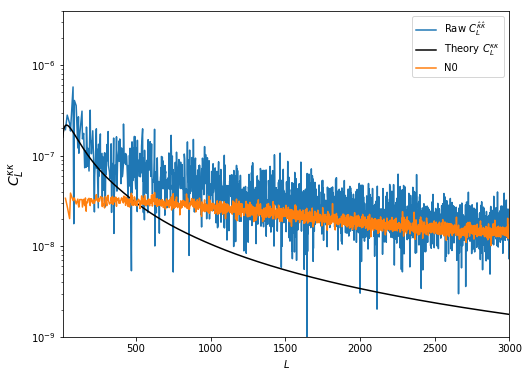

In [14]:
# Plot the N0 bias with the theory curve and the raw spectrum
t = lambda l: (l*(l+1))**2/4
ell = np.arange(len(tt_spec_biased))

pl.figure(figsize=(8,6))
pl.plot(ell[np.nonzero(tt_spec_biased)], t(ell)[np.nonzero(tt_spec_biased)]*tt_spec_biased[np.nonzero(tt_spec_biased)], label='Raw $C_L^{\hat{\kappa}\hat{\kappa}}$')
pl.plot(par.cl_unl['L'], t(par.cl_unl['L'])*par.cl_unl['PP'], 'k', label='Theory $C_L^{\kappa\kappa}$')
pl.plot(ell[np.nonzero(n0_bias.get_cl())], t(ell[np.nonzero(n0_bias.get_cl())])*n0_bias.get_cl()[np.nonzero(n0_bias.get_cl())], label='N0')

pl.yscale('log')
pl.xlim([10, 3000])
pl.ylim([1e-9,4e-6])
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.legend()
pl.xlabel('$L$')

We expect most of power of the raw lensing spectrum to come from N0 in the range where the blue traces have information. So the orange line matching the blue is expected. At lower L, we expect the blue line to peak up a bit because there we are signal dominated. It's hard to see it with the noise right now. That's why binning is needed.

Before we get to binning, let's walk through the N1 calculation.

## 3. N1 calculation  <a class="anchor" id="N1"></a>

As mentioned earlier, the N1 comes from the secondary contraction of the trispectum ($<1324>$ and $<1423>$). Intuitively, one can think of it as spurious correlations between the CMB and $\phi$. 

So we want to construct sim skies with different CMB realizations that are lensed by the same $\phi$. We need to subtract N0 from it (because the CMB realizations gives N0 power). So we have:

$
N_L^{(1)} = \\
\Big \langle
   +C_L^{\hat{\phi}\hat{\phi}}[\bar{U}_{\phi^1,{\rm MC}},\bar{V}_{\phi^1,{\rm MC'}},\bar{X}_{\phi^1,{\rm MC}},\bar{Y}_{\phi^1,{\rm MC'}}] \\
   +C_L^{\hat{\phi}\hat{\phi}}[\bar{U}_{\phi^1,{\rm MC}},\bar{V}_{\phi^1,{\rm MC'}},\bar{X}_{\phi^1,{\rm MC'}},\bar{Y}_{\phi^1,{\rm MC}}] \\
   -C_L^{\hat{\phi}\hat{\phi}}[\bar{U}_{\rm MC},\bar{V}_{\rm MC'},\bar{X}_{\rm MC},\bar{Y}_{\rm MC'}] \\
   -C_L^{\hat{\phi}\hat{\phi}}[\bar{U}_{\rm MC},\bar{V}_{\rm MC'},\bar{X}_{\rm MC'},\bar{Y}_{\rm MC}] 
  \Big \rangle_{{\rm MC,MC'}}\,,
$

The last two lines get the N0 subtracted. The first two lines are same as the N0 calculation, but with fixed $\phi^1$ realizations. 

The implementation of the N1 calculation is the same as N0. The input `qecl` classes are built from a different set of sims. Specifically, in the parameter file, the `qest` for the N1 are:

```python
# sim(t1p1) x sim(t2p1)
qest_ss2_nofg = sl.quadest.QuadEstLib(cl_unl, cl_len, cinv_len_t1_nofg,
                                      ivfs2=sl.cinv.CinvFiltSim(cinv_len_t2_nofg, roll=0),
                                      lib_dir=bdir+'par_%s/qest_len_ss2_nofg/' % qest_prefix)

# simA x simB, used to subtract from N1
qest_ss_nofg = sl.quadest.QuadEstLib(cl_unl, cl_len, cinv_len_t1_nofg,
                                     ivfs2=sl.cinv.CinvFiltSim(cinv_len_t1_nofg, roll=2),
                                     lib_dir=bdir+'par_%s/qest_len_ss_nofg/' % qest_prefix)
```
For `qecl`:

```python
qecl_len_ss_nofg = sl.quadest_cl.QuadEstCl(qest_ss_nofg,
                                           lib_dir=bdir+'par_%s/qecl_len_ss_nofg/' % qest_prefix,
                                           mc_sims_mf=None)

qecl_len_ss2_nofg = sl.quadest_cl.QuadEstCl(qest_ss2_nofg,
                                            lib_dir=bdir+'par_%s/qecl_len_ss2_nofg/' % qest_prefix,
                                            mc_sims_mf=None)
```

Here
   * In `qest_ss2_nofg`: `cinv_len_t1_nofg` and `cinv_len_t2_nofg` are two sets of filtered maps with different CMB realizations lensed with the same lensing field. This `qest` class is fed into `qecl_len_ss_nofg`, which is used for calculating the first 2 lines in the N1 equation above.
   * `qecl_len_ss_nofg` is used for estimating the N0. It is fed to `qecl_len_ss2_nofg`.

In [15]:
# Now we calculate N1
sim_stats_ss_nofg = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_ss_nofg, par.qecl_len_dd, par.mc_sims_n1, lbins=np.arange(0,cl_max+1), qcr_mc=qcr_mc, k1='Phi_TT')
sim_stats_ss2_nofg = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_ss2_nofg, par.qecl_len_dd, par.mc_sims_n1, lbins=np.arange(0,cl_max+1), qcr_mc=qcr_mc, k1='Phi_TT')

n1_bias = (sim_stats_ss2_nofg.avg() - sim_stats_ss_nofg.avg()) * 2.

 [00:00:00] accumulating qcl, (k1,k2)=(Phi_TT,Phi_TT) > 09%

/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)


0:00:01] accumulating qcl, (k1,k2)=(Phi_TT,Phi_TT) ---------> 98%

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'$L$')

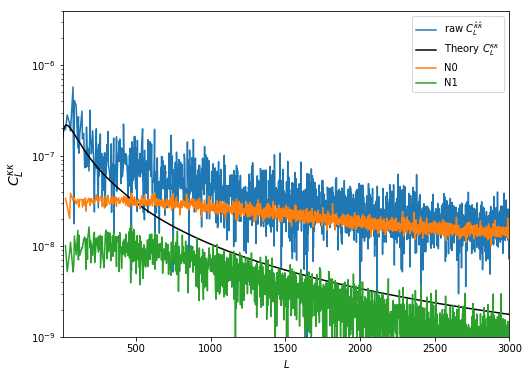

In [16]:
# Plot the N1 bias; with the raw spectrum, N0, and the theory curve
t = lambda l: (l*(l+1))**2/4
ell = np.arange(len(tt_spec_biased))

pl.figure(figsize=(8,6))
pl.plot(ell[np.nonzero(tt_spec_biased)], t(ell)[np.nonzero(tt_spec_biased)]*tt_spec_biased[np.nonzero(tt_spec_biased)], label='raw $C_L^{\hat{\kappa}\hat{\kappa}}$')
pl.plot(par.cl_unl['L'], t(par.cl_unl['L'])*par.cl_unl['PP'], 'k', label='Theory $C_L^{\kappa\kappa}$')
pl.plot(ell[np.nonzero(n0_bias.get_cl())], t(ell[np.nonzero(n0_bias.get_cl())])*n0_bias.get_cl()[np.nonzero(n0_bias.get_cl())], label='N0')
pl.plot(ell[np.nonzero(n1_bias.get_cl())], t(ell[np.nonzero(n1_bias.get_cl())])*n1_bias.get_cl()[np.nonzero(n1_bias.get_cl())], label='N1')

pl.yscale('log')
pl.xlim([10, 3000])
pl.ylim([1e-9,4e-6])
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.legend()
pl.xlabel('$L$')

The unbinned N1 is noisy. But it is in the right ballpack in terms of amplitude. 

## 4. Binning <a class="anchor" id="binning"></a>

As we have seen, without binning, the spectra are quite noisy.

We bin the spectra into bandpowers using $C_L^{\phi\phi}/\mathrm{Var}(C_L^{\phi\phi} + N_L^{\phi\phi})$ weights, employing the amplitude-per-bin weighing method outlined in section 2.3 of Planck 2013 (https://arxiv.org/pdf/1303.5077v2.pdf).

We have different options for implementing the weights (depending on whether one chooses to use sims to get the variance in the denominator or use analytic estimates). Here we will use analytical weighting (with lensing sample variance added).

SPT3G has a `rebin` function in `map_spectrum_classes.py` that `get_sim_stats` uses if you put in argument `weight_fun`. However, this does not do the amplitude-per-bin weighing, so we choose to use the Planck method manually instead. We want amplitude-per-bin weighing because our weights are proportional to the number of modes, which means that the high ell edge of each bin gets weighed more (higher ells means higher number of modes). But since we are dealing with a red spectrum (i.e. higher ells have lower values), this results in a suppression, which we want to avoid. 

In [17]:
k1 = 'Phi_TT'
k2 = 'Phi_TT'
idx = 161
clpp = par.cl_unl['PP'][0:5000]

# Define the ell bins
lslog = np.log(np.arange(100,2001,1)) # Set ell range 100 < L < 2000
lbins = np.exp(np.linspace(lslog[0], lslog[-1], 11))
bin_centers = np.zeros_like(lbins)[:-1]
for i in range(len(bin_centers)):
    bin_centers[i] = lbins[i] + (lbins[i+1] - lbins[i])/2
    
# Below, we just use the rebin function to bin, not weigh
clpp_binned = map_spectrum_classes.MapSpectrum1D(qcr_an.lbins, clpp, qcr_an.spec_type, qcr_an.parent).rebin(lbins)

# Assume the response is approximately 1/N0, so sqrt(1/qcr_an) is roughly N0 (remember, qcr is response squared)
qcr_smooth = scipy.ndimage.gaussian_filter1d(np.real(qcr_an.get_cl()), 50) # Do smoothing to remove zeros to prevent dividing by zeros
n0_approx_vals = np.sqrt(1./qcr_smooth)
n0_approx = map_spectrum_classes.MapSpectrum1D(qcr_an.lbins, n0_approx_vals, qcr_an.spec_type, qcr_an.parent) # Recast into MapSpectrum1D type

# Prepare the binning; set up to follow Planck 2013 method to do binning using variance V
# The variance is is (2/((2*ell+1)*fsky))*(Cl+Nl)^2 where (2*ell+1)*fsky is approximately the number of modes
V = 2/qcr_an.get_num_modes() * (clpp+n0_approx)**2
B = clpp/V
unbinned_denom = clpp**2 / V
for jj in range(len(bin_centers)):
    lmin = lbins[jj]
    lmax = lbins[jj+1]
    denominator = np.sum(unbinned_denom[int(lmin):int(lmax)])
    B[int(lmin):int(lmax)] /= denominator

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5,0,'$L$')

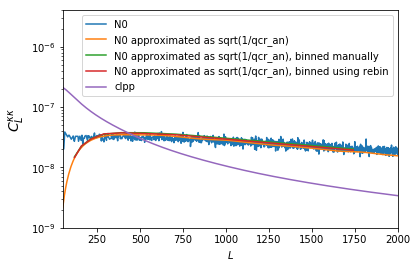

In [18]:
# Sanity checks... Make sure that our estimate of N0 is correct, and check that rebin does what we expect
n0_approx_binned_using_rebin = n0_approx.rebin(lbins)
n0_approx_binned_manual = np.zeros_like(bin_centers)
for i in range(len(bin_centers)):
    n0_approx_binned_manual[i] = np.mean(n0_approx[lbins[i].astype(int):lbins[i+1].astype(int)])

# Estimate of N0 as 1/sqrt(qcr_an) is worse at lower ells
pl.plot(ell[np.nonzero(n0_bias)], t(ell[np.nonzero(n0_bias)])*n0_bias[np.nonzero(n0_bias)], label='N0')
pl.plot(ell, t(ell)*n0_approx, label='N0 approximated as sqrt(1/qcr_an)')
pl.plot(bin_centers, t(bin_centers)*n0_approx_binned_manual, label='N0 approximated as sqrt(1/qcr_an), binned manually')
pl.plot(bin_centers, t(bin_centers)*n0_approx_binned_using_rebin, label='N0 approximated as sqrt(1/qcr_an), binned using rebin')
pl.plot(ell, t(ell)*clpp, label='clpp')
pl.yscale('log')
pl.ylim([1e-9,4e-6])
pl.xlim(50,2000)
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.legend()
pl.xlabel('$L$')

/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5,0,'$L$')

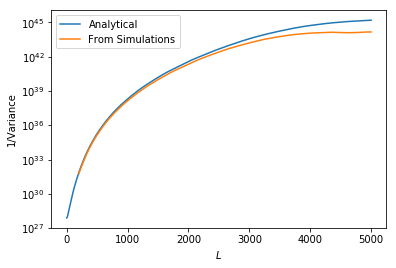

In [19]:
# Another sanity check: get the 1/variance from simulations and see if it agrees with analytic estimate
qcr = par.qecl_len_dd.get_qcr_lm(k1, k2=k2) * qcr_mc # Spectrum of the response
# Get all sims for clpp; need this for the variance
clpp_sims_all = np.zeros((len(par.mc_sims_var),5000))
for ii, idx in enumerate(par.mc_sims_var):
    qcl_sim_idx = par.qecl_len_dd.get_sim_qcl_lm(k1, idx, k2=k2)
    clpp_sims_all[ii] = qcl_sim_idx/qcr # This already includes the noise
# Get the variance
clpp_sims_var = np.var(clpp_sims_all, axis=0) # Variance of clpp + nlpp across sims

sim_inv_var = 1. / clpp_sims_var
sim_inv_var = np.where(qcr_an.get_num_modes() > 0, sim_inv_var, 0) # Where num modes is nonzero, take sim_inv_var, otherwise put 0
sim_inv_var = scipy.ndimage.gaussian_filter1d(sim_inv_var, 50)
an_inv_var = scipy.ndimage.gaussian_filter1d(1/V, 50)

pl.plot(an_inv_var, label='Analytical')
pl.plot(sim_inv_var, label= 'From Simulations')
pl.ylabel('1/Variance')
pl.legend()
pl.yscale('log')
pl.xlabel('$L$')

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


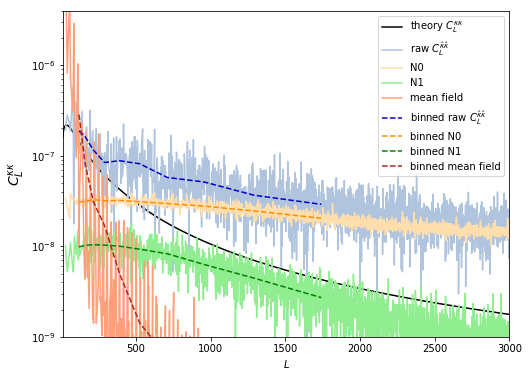

In [20]:
# Get binned amplitudes for raw spectrum, N0, N1, and mean field, and plot, just for visualization
mf_spec = map_analysis.mapffts_to_powerspectra(input1=par.qest_dd.get_sim_qft_mf('Phi_TT', par.mc_sims_mf), lbins=np.arange(0,5001))['TT']
A_raw = np.zeros_like(bin_centers)
A_n0 = np.zeros_like(bin_centers)
A_n1 = np.zeros_like(bin_centers)
A_mf = np.zeros_like(bin_centers)
for ii in range(len(bin_centers)):
    lmin = lbins[ii]
    lmax = lbins[ii+1]
    A_raw[ii] = np.sum(np.array(tt_spec_biased[int(lmin):int(lmax)]) * B[int(lmin):int(lmax)])
    A_n0[ii] = np.sum(np.array(n0_bias[int(lmin):int(lmax)]) * B[int(lmin):int(lmax)])
    A_n1[ii] = np.sum(np.array(n1_bias[int(lmin):int(lmax)]) * B[int(lmin):int(lmax)])
    A_mf[ii] = np.sum(np.array(mf_spec[int(lmin):int(lmax)]/(qcr_an*qcr_mc)[int(lmin):int(lmax)]) * B[int(lmin):int(lmax)])

pl.figure(figsize=(8,6))
pl.plot(par.cl_unl['L'], t(par.cl_unl['L'])*par.cl_unl['PP'], 'k', label='theory $C_L^{\kappa\kappa}$')
pl.plot(ell[np.nonzero(tt_spec_biased)], t(ell)[np.nonzero(tt_spec_biased)]*tt_spec_biased[np.nonzero(tt_spec_biased)], label='raw $C_L^{\hat{\kappa}\hat{\kappa}}$', color='lightsteelblue')
pl.plot(ell[np.nonzero(n0_bias.get_cl())], t(ell[np.nonzero(n0_bias.get_cl())])*n0_bias.get_cl()[np.nonzero(n0_bias.get_cl())], label='N0', color='navajowhite')
pl.plot(ell[np.nonzero(n1_bias.get_cl())], t(ell[np.nonzero(n1_bias.get_cl())])*n1_bias.get_cl()[np.nonzero(n1_bias.get_cl())], label='N1', color='lightgreen')
pl.plot(ell[np.nonzero(mf_spec)], t(ell[np.nonzero(mf_spec)])*mf_spec[np.nonzero(mf_spec)]/(qcr_an*qcr_mc)[np.nonzero(mf_spec)], label='mean field', color='lightsalmon')

pl.plot(bin_centers, A_raw*clpp[bin_centers.astype(int)]*t(bin_centers), '--', label='binned raw $C_L^{\hat{\kappa}\hat{\kappa}}$', color='mediumblue')
pl.plot(bin_centers, A_n0*clpp[bin_centers.astype(int)]*t(bin_centers), '--', label='binned N0', color='darkorange')
pl.plot(bin_centers, A_n1*clpp[bin_centers.astype(int)]*t(bin_centers), '--', label='binned N1', color='green')
pl.plot(bin_centers, A_mf*clpp[bin_centers.astype(int)]*t(bin_centers), '--', label='binned mean field', color='firebrick')

pl.yscale('log')
pl.xlim([10, 3000])
pl.ylim([1e-9,4e-6])
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.legend()
pl.xlabel('$L$')
pl.show()

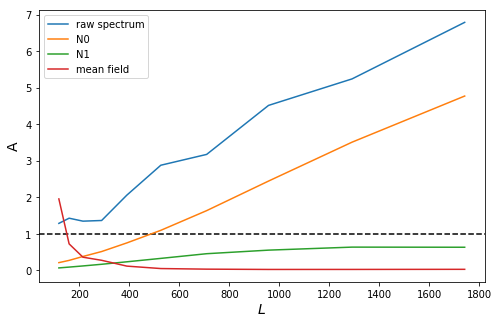

In [21]:
pl.figure(figsize=(8,5))
pl.axhline(y=1.0, ls='--', color='k')

# Plot our amplitude A used in the binning; it would be 1 if it was identical to theory clpp
pl.plot(bin_centers, A_raw, label='raw spectrum')
pl.plot(bin_centers, A_n0, label='N0')
pl.plot(bin_centers, A_n1, label='N1')
pl.plot(bin_centers, A_mf, label='mean field')
pl.ylabel('A', fontsize=14)
pl.legend()
pl.xlabel(r'$L$',fontsize=14)
pl.show()

### Binned lensing bandpowers

We obtain the lensing bandpowers by taking the raw spectrum, and then subtracing from it the N0 and the N1 spectra, and then binning them.

We estimate the uncertainties of the bandpowers by measuring the debiased lensing spectrum from simulations.

In [22]:
def get_bandpower_uncertainties(qcllib, mc_sims, lbins, fiducial_clpp=None, variance=None, qcr_mc=None, k1='Phi_TT', k2='Phi_TT'):
    '''
    If you want to do amplitude-per-bin weighing as in Planck 2013, you must have fiducial_clpp and variance
    arguments.
    If these are not given, then no weighing will be done.
    '''
    if qcr_mc is None:
        qcr_mc = 1
    qcr = qcllib.get_qcr_lm(k1, k2=k2) * qcr_mc # Spectrum of the response
    if fiducial_clpp is not None and variance is not None:
        B = fiducial_clpp/variance
        unbinned_denom = fiducial_clpp**2 / variance
        for jj in range(len(lbins)-1):
            lmin = lbins[jj]
            lmax = lbins[jj+1]
            denominator = np.sum(unbinned_denom[int(lmin):int(lmax)])
            B[int(lmin):int(lmax)] /= denominator
    bin_centers = np.zeros_like(lbins)[:-1]
    for i in range(len(bin_centers)):
        bin_centers[i] = lbins[i] + (lbins[i+1] - lbins[i])/2
    
    # Get all sims for clpp; need this for the uncertainties
    clpp_sims_all_binned = np.zeros((len(mc_sims),len(lbins)-1))
    amplitude_all_binned = np.zeros((len(mc_sims),len(lbins)-1))
    for ii, idx in enumerate(mc_sims):
        qcl_sim_idx = qcllib.get_sim_qcl_lm(k1, idx, k2=k2)
        clpp_sim_with_response = qcl_sim_idx/qcr
        
        if fiducial_clpp is not None and variance is not None:
            # Bin and weigh in the same way as we bin and weigh the debiased spectrum; using Planck 2013 method
            amplitude = np.zeros_like(lbins)[:-1]
            for jj in range(len(lbins)-1):
                lmin = lbins[jj]
                lmax = lbins[jj+1]
                clpp_sim_chunk = np.array(clpp_sim_with_response[int(lmin):int(lmax)])
                amplitude[jj] = np.sum(clpp_sim_chunk * B[int(lmin):int(lmax)])
            clpp_sims_all_binned[ii] = amplitude*fiducial_clpp[bin_centers.astype(int)]
            amplitude_all_binned[ii] = amplitude
        else:
            clpp_sims_all_binned[ii] = map_spectrum_classes.MapSpectrum1D(qcr.lbins, clpp_sim_with_response, qcr.spec_type, qcr.parent).rebin(lbins)

    # Get the uncertainties
    clpp_sim_std_binned = np.std(clpp_sims_all_binned, axis=0) # Standard deviation of clpp across sims
    if fiducial_clpp is not None and variance is not None:
        amplitude_std = np.std(amplitude_all_binned, axis=0)
    else:
        amplitude_std = None
    return (clpp_sim_std_binned, amplitude_std)
    
(clpp_sim_std_binned, amplitude_std) = get_bandpower_uncertainties(par.qecl_len_dd, par.mc_sims_var, lbins=lbins, fiducial_clpp=clpp, variance=V, qcr_mc=qcr_mc, k1=k1, k2=k2)

/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


 [00:00:00] accumulating qcl, (k1,k2)=(Phi_TT,Phi_TT) > 01%

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)


0:00:01] accumulating qcl, (k1,k2)=(Phi_TT,Phi_TT) ---------> 98%

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


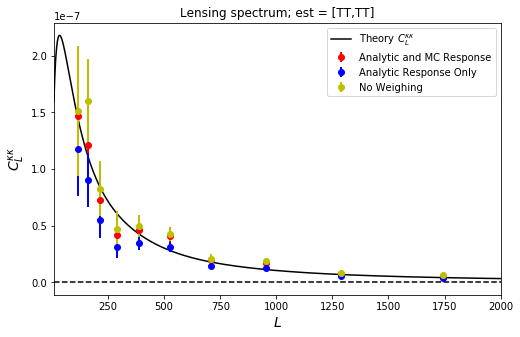

In [23]:
pl.figure(figsize=(8,5))
t = lambda l: (l*(l+1))**2/4 # Conversion to kappa

# Plot the theory spectrum
pl.plot(par.cl_unl['L'], t(par.cl_unl['L'])*par.cl_unl['PP'], 'k', label='Theory $C_L^{\kappa\kappa}$')
pl.axhline(y=0.0, ls='--', color='k')

# Bin and weigh
A = np.zeros_like(bin_centers)
for ii in range(len(bin_centers)):
    lmin = lbins[ii]
    lmax = lbins[ii+1]
    debiased_spec = np.array(tt_spec_biased[int(lmin):int(lmax)]) - np.array(n0_bias[int(lmin):int(lmax)]) - np.array(n1_bias[int(lmin):int(lmax)])
    A[ii] = np.sum(debiased_spec * B[int(lmin):int(lmax)])
binned_debiased_spec = A*clpp[bin_centers.astype(int)]
# Plot our debiased spectrum
# Higher error on lower ells are from cosmic variance
pl.errorbar(bin_centers, t(bin_centers)*binned_debiased_spec, yerr=t(bin_centers)*clpp_sim_std_binned,
            color='r', marker='o', markerfacecolor='r',
            ls='None', linewidth=2, capthick=2, zorder=5, label='Analytic and MC Response',
           )

# For comparison with no MC response
sim_stats_ss_an = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_ss, par.qecl_len_dd, par.mc_sims_n0, lbins=np.arange(0,cl_max+1), k1='Phi_TT')
n0_bias_an = sim_stats_ss_an.avg() * 2.
sim_stats_ss_nofg_an = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_ss_nofg, par.qecl_len_dd, par.mc_sims_n1, lbins=np.arange(0,cl_max+1), k1='Phi_TT')
sim_stats_ss2_nofg_an = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_ss2_nofg, par.qecl_len_dd, par.mc_sims_n1, lbins=np.arange(0,cl_max+1), k1='Phi_TT')
n1_bias_an = (sim_stats_ss2_nofg_an.avg() - sim_stats_ss_nofg_an.avg()) * 2.
A_an = np.zeros_like(bin_centers)
for ii in range(len(bin_centers)):
    lmin = lbins[ii]
    lmax = lbins[ii+1]
    debiased_spec = np.array(tt_spec_biased_an[int(lmin):int(lmax)]) - np.array(n0_bias_an[int(lmin):int(lmax)]) - np.array(n1_bias_an[int(lmin):int(lmax)])
    A_an[ii] = np.sum(debiased_spec * B[int(lmin):int(lmax)])
binned_debiased_spec_an = A_an*clpp[bin_centers.astype(int)]
clpp_sim_std_an = get_bandpower_uncertainties(par.qecl_len_dd, par.mc_sims_var, lbins=lbins, fiducial_clpp=clpp, variance=V, qcr_mc=None, k1=k1, k2=k2)[0]
pl.errorbar(bin_centers, t(bin_centers)*binned_debiased_spec_an, yerr=t(bin_centers)*clpp_sim_std_an,
            color='b', marker='o', markerfacecolor='b',
            ls='None', linewidth=2, capthick=2, zorder=5, label='Analytic Response Only',
           )

# For comparison with no weighing
unweighed_debiased_spec = tt_spec_biased.rebin(lbins) - n0_bias.rebin(lbins) - n1_bias.rebin(lbins)
clpp_sim_std_unweighed = get_bandpower_uncertainties(par.qecl_len_dd, par.mc_sims_var, lbins=lbins, qcr_mc=qcr_mc, k1=k1, k2=k2)[0]
pl.errorbar(bin_centers, t(bin_centers)*unweighed_debiased_spec, yerr=t(bin_centers)*clpp_sim_std_unweighed,
            color='y', marker='o', markerfacecolor='y',
            ls='None', linewidth=2, capthick=2, zorder=5, label='No Weighing',
           )

pl.xlabel(r'$L$',fontsize=14)
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.xlim(10, 2000)
pl.legend()
pl.title('Lensing spectrum; est = [%s,%s]'%(k1[4:],k2[4:]))
pl.show()

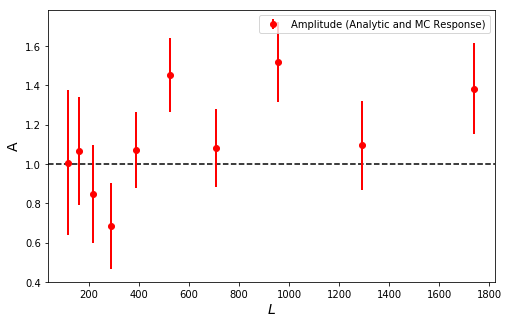

In [24]:
pl.figure(figsize=(8,5))
pl.axhline(y=1.0, ls='--', color='k')

# Plot our amplitude A
pl.errorbar(bin_centers, A, yerr=amplitude_std,
            color='r', marker='o', markerfacecolor='r',
            ls='None', linewidth=2, capthick=2, zorder=5, label='Amplitude (Analytic and MC Response)',
           )
pl.legend()
pl.ylabel('A', fontsize=14)
pl.xlabel(r'$L$',fontsize=14)
pl.show()

### Check of Bias

Above, we plotted the lensing bandpowers for just sim 161. The final check to confirm that what we have is unbiased is to do it for all sims from 161 to 500, and average them.

 [00:00:00] accumulating spectra, (k1,k2)=(Phi_TT,Phi_TT) > 09%

/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


 [00:00:00] accumulating spectra, (k1,k2)=(Phi_TT,Phi_TT) > 09%----> 99%

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


 [00:00:00] accumulating spectra, (k1,k2)=(Phi_TT,Phi_TT) > 03%----> 99%

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:50: ComplexWarning: Casting complex values to real discards the imaginary part


0:00:05] accumulating spectra, (k1,k2)=(Phi_TT,Phi_TT) ---------> 99%

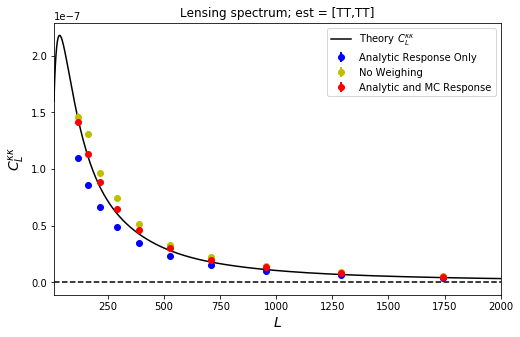

In [25]:
pl.figure(figsize=(8,5))
t = lambda l: (l*(l+1))**2/4 # Conversion to kappa

# Plot the theory spectrum
pl.plot(par.cl_unl['L'], t(par.cl_unl['L'])*par.cl_unl['PP'], 'k', label='Theory $C_L^{\kappa\kappa}$')
pl.axhline(y=0.0, ls='--', color='k')

# Get the raw spectrum minus N0 minus N1 (tt_spec_biased is just sim 161)
k1 = "Phi_TT"
k2 = "Phi_TT"
binned_debiased_spec_all = np.zeros((len(par.mc_sims_var),len(lbins)-1))
A_all = np.zeros((len(par.mc_sims_var),len(lbins)-1))
for i, idx in sl.utils.enumerate_progress(par.mc_sims_var, "accumulating spectra, (k1,k2)=(%s,%s)"%(k1,k2), clear=True):
    qcl_sim_idx = par.qecl_len_dd.get_sim_qcl_lm(k1, idx, k2=k2)
    clpp_sim_with_response = qcl_sim_idx/qcr
    A_idx = np.zeros_like(bin_centers)
    for ii in range(len(bin_centers)):
        lmin = lbins[ii]
        lmax = lbins[ii+1]
        debiased_spec = np.array(clpp_sim_with_response[int(lmin):int(lmax)]) - np.array(n0_bias[int(lmin):int(lmax)]) - np.array(n1_bias[int(lmin):int(lmax)])
        A_idx[ii] = np.sum(debiased_spec * B[int(lmin):int(lmax)])
    binned_debiased_spec_all[i] = A_idx*clpp[bin_centers.astype(int)]
    A_all[i] = A_idx
binned_debiased_spec_avg = np.mean(binned_debiased_spec_all, axis=0)
A_avg = np.mean(A_all, axis=0)

# For comparison with no MC response
binned_debiased_spec_all_an = np.zeros((len(par.mc_sims_var),len(lbins)-1))
A_all_an = np.zeros((len(par.mc_sims_var),len(lbins)-1))
for i, idx in sl.utils.enumerate_progress(par.mc_sims_var, "accumulating spectra, (k1,k2)=(%s,%s)"%(k1,k2), clear=True):
    qcl_sim_idx = par.qecl_len_dd.get_sim_qcl_lm(k1, idx, k2=k2)
    clpp_sim_with_response = qcl_sim_idx/qcr_an
    A_idx = np.zeros_like(bin_centers)
    for ii in range(len(bin_centers)):
        lmin = lbins[ii]
        lmax = lbins[ii+1]
        debiased_spec = np.array(clpp_sim_with_response[int(lmin):int(lmax)]) - np.array(n0_bias_an[int(lmin):int(lmax)]) - np.array(n1_bias_an[int(lmin):int(lmax)])
        A_idx[ii] = np.sum(debiased_spec * B[int(lmin):int(lmax)])
    binned_debiased_spec_all_an[i] = A_idx*clpp[bin_centers.astype(int)]
    A_all_an[i] = A_idx
binned_debiased_spec_avg_an = np.mean(binned_debiased_spec_all_an, axis=0)
A_avg_an = np.mean(A_all_an, axis=0)

# For comparison with no weighing
# This will be biased up since in bins where the spectrum is concave up, the average is higher than the center
unweighed_debiased_spec_all = np.zeros((len(par.mc_sims_var),len(lbins)-1))
for i, idx in sl.utils.enumerate_progress(par.mc_sims_var, "accumulating spectra, (k1,k2)=(%s,%s)"%(k1,k2), clear=True):
    qcl_sim_idx = par.qecl_len_dd.get_sim_qcl_lm(k1, idx, k2=k2)
    clpp_sim_with_response = qcl_sim_idx/qcr
    unweighed_debiased_spec_all[i] = clpp_sim_with_response.rebin(lbins) - n0_bias.rebin(lbins) - n1_bias.rebin(lbins)
unweighed_debiased_spec_avg = np.mean(unweighed_debiased_spec_all, axis=0)

# Plot
# High error on lower ells are from cosmic variance
# Deviation at lower ells may be from inaccurate estimate of N0 ~ 1/sqrt(qcr_an) at lower ells
pl.errorbar(bin_centers, t(bin_centers)*binned_debiased_spec_avg_an, yerr=t(bin_centers)*clpp_sim_std_an/np.sqrt(len(par.mc_sims_var)),
            color='b', marker='o', markerfacecolor='b',
            ls='None', linewidth=2, capthick=2, zorder=5, label='Analytic Response Only',
           )
pl.errorbar(bin_centers, t(bin_centers)*unweighed_debiased_spec_avg, yerr=t(bin_centers)*clpp_sim_std_unweighed/np.sqrt(len(par.mc_sims_var)),
            color='y', marker='o', markerfacecolor='y',
            ls='None', linewidth=2, capthick=2, zorder=5, label='No Weighing',
           )
pl.errorbar(bin_centers, t(bin_centers)*binned_debiased_spec_avg, yerr=t(bin_centers)*clpp_sim_std_binned/np.sqrt(len(par.mc_sims_var)),
            color='r', marker='o', markerfacecolor='r',
            ls='None', linewidth=2, capthick=2, zorder=5, label='Analytic and MC Response',
           )

pl.xlabel(r'$L$',fontsize=14)
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.xlim(10, 2000)
pl.legend()
pl.title('Lensing spectrum; est = [%s,%s]'%(k1[4:],k2[4:]))
pl.show()

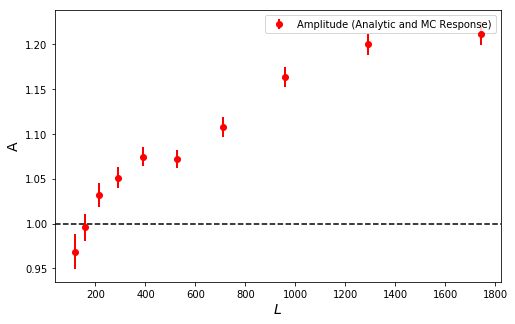

In [26]:
pl.figure(figsize=(8,5))
pl.axhline(y=1.0, ls='--', color='k')

# Plot our amplitude A
pl.errorbar(bin_centers, A_avg, yerr=amplitude_std/np.sqrt(len(par.mc_sims_var)),
            color='r', marker='o', markerfacecolor='r',
            ls='None', linewidth=2, capthick=2, zorder=5, label='Amplitude (Analytic and MC Response)',
           )

pl.legend()
pl.ylabel('A', fontsize=14)
pl.xlabel(r'$L$',fontsize=14)
pl.show()

## 5. Other Pairs of Estimators <a class="anchor" id="estimators"></a>

We have been working with the TT estimator lensing spectrum (four point function TTTT), but we can also do it for other pairs of estimators.

In [27]:
k1 = 'Phi_set'
k2 = 'Phi_set'

# Get analytic response
qcr_an_all = par.qecl_len_dd.get_qcr_lm(k1, k2=k2)

# Get the MC response correction
tmp_dd = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_dk, par.qecl_len_dd, par.mc_sims_qcr_mc, lbins=np.arange(0,cl_max+1), k1=k1, k2=k2)
amp = -1*tmp_dd.avg()[:5000]/par.cl_unl['PP'][:5000]
qcr_mc_all = np.array(amp**2)

# Total qcr
qcr_all = qcr_an_all * qcr_mc_all
    
# N0
sim_stats_ss_all = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_ss, par.qecl_len_dd, par.mc_sims_n0,
                                 lbins=np.arange(0,cl_max+1), qcr_mc=qcr_mc,
                                 k1='Phi_set', k2='Phi_set')
n0_bias_all = sim_stats_ss_all.avg() * 2.
    
# N1
sim_stats_ss_nofg_all = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_ss_nofg, par.qecl_len_dd,
                                      par.mc_sims_n1, lbins=np.arange(0,cl_max+1), qcr_mc=qcr_mc,
                                      k1='Phi_set', k2='Phi_set')
sim_stats_ss2_nofg_all = sl.spectra_stat.BinnedClStats.get_sim_stats(par.qecl_len_ss2_nofg, par.qecl_len_dd,
                                       par.mc_sims_n1, lbins=np.arange(0,cl_max+1), qcr_mc=qcr_mc,
                                       k1='Phi_set', k2='Phi_set')
n1_bias_all = (sim_stats_ss2_nofg_all.avg() - sim_stats_ss_nofg_all.avg()) * 2.

# Assume the response is approximately 1/N0, so sqrt(1/qcr_an) is roughly N0 (remember, qcr is response squared)
qcr_smooth = scipy.ndimage.gaussian_filter1d(np.real(qcr_an_all.get_cl()), 50) # Do smoothing to remove zeros to prevent dividing by zeros
n0_approx_vals = np.sqrt(1./qcr_smooth)
n0_approx_all = map_spectrum_classes.MapSpectrum1D(qcr_an_all.lbins, n0_approx_vals, qcr_an_all.spec_type, qcr_an_all.parent) # Recast into MapSpectrum1D type

# Prepare the binning
clpp_binned = map_spectrum_classes.MapSpectrum1D(qcr.lbins, clpp, qcr.spec_type, qcr.parent).rebin(lbins)
# The variance is is (2/((2*ell+1)*fsky))*(Cl+Nl)^2 where (2*ell+1)*fsky is approximately the number of modes
V_all = 2/qcr_an_all.get_num_modes() * (clpp+n0_approx_all)**2
B_all = clpp/V_all
unbinned_denom_all = clpp**2 / V_all
for jj in range(len(lbins)-1):
    lmin = lbins[jj]
    lmax = lbins[jj+1]
    denominator = np.sum(unbinned_denom_all[int(lmin):int(lmax)])
    B_all[int(lmin):int(lmax)] /= denominator

# Bin and weigh
binned_debiased_spec_all = np.zeros((len(par.mc_sims_var),len(lbins)-1))
A_all = np.zeros((len(par.mc_sims_var),len(lbins)-1))
for i, idx in sl.utils.enumerate_progress(par.mc_sims_var, "accumulating spectra, (k1,k2)=(%s,%s)"%(k1,k2), clear=True):
    # The phi here is mean field subtracted, and also intrinsically noise variance weighted
    qcl_sim_idx = par.qecl_len_dd.get_sim_qcl_lm(k1, idx, k2=k2)
    clpp_sim_with_response = qcl_sim_idx/qcr_all
    A_idx = np.zeros_like(bin_centers)
    for ii in range(len(bin_centers)):
        lmin = lbins[ii]
        lmax = lbins[ii+1]
        debiased_spec = np.array(clpp_sim_with_response[int(lmin):int(lmax)]) - np.array(n0_bias_all[int(lmin):int(lmax)]) - np.array(n1_bias_all[int(lmin):int(lmax)])
        A_idx[ii] = np.sum(debiased_spec * B_all[int(lmin):int(lmax)])
    binned_debiased_spec_all[i] = A_idx*clpp[bin_centers.astype(int)]
    A_all[i] = A_idx
binned_debiased_spec_avg_all = np.mean(binned_debiased_spec_all, axis=0)
A_avg_all = np.mean(A_all, axis=0)

# Uncertainties
(clpp_sim_std_binned_all, amplitude_std_all) = get_bandpower_uncertainties(par.qecl_len_dd, par.mc_sims_var,
                                                                           lbins=lbins, fiducial_clpp=clpp,
                                                                           variance=V_all, qcr_mc=qcr_mc_all,
                                                                           k1=k1, k2=k2)

 [00:00:00] accumulating qcl, (k1,k2)=(Phi_set,Phi_set) > 02%

/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:491: RuntimeWarning: invalid value encountered in true_divide
  *args, **kwargs)


 [00:00:00] accumulating spectra, (k1,k2)=(Phi_set,Phi_set) > 06%> 98%

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide
/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:59: ComplexWarning: Casting complex values to real discards the imaginary part


0:00:02] accumulating spectra, (k1,k2)=(Phi_set,Phi_set) ---------> 99%

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


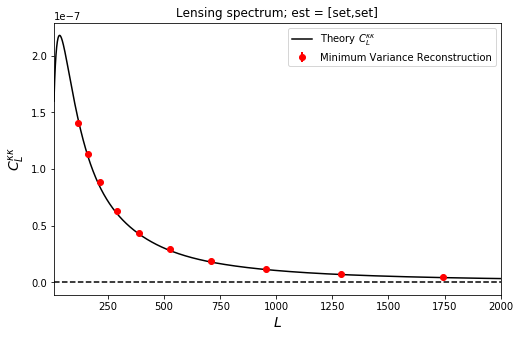

In [28]:
pl.figure(figsize=(8,5))
t = lambda l: (l*(l+1))**2/4 # Conversion to kappa

# Plot the theory spectrum
pl.plot(par.cl_unl['L'], t(par.cl_unl['L'])*par.cl_unl['PP'], 'k', label='Theory $C_L^{\kappa\kappa}$')
pl.axhline(y=0.0, ls='--', color='k')

# Plot minimum variance reconstruction
pl.errorbar(bin_centers, t(bin_centers)*binned_debiased_spec_avg_all, yerr=t(bin_centers)*clpp_sim_std_binned_all/np.sqrt(len(par.mc_sims_var)),
            color='r', marker='o', markerfacecolor='r',
            ls='None', linewidth=2, capthick=2, zorder=5, label='Minimum Variance Reconstruction',
           )

pl.xlabel(r'$L$',fontsize=14)
pl.ylabel('$C_L^{\kappa\kappa}$', fontsize=14)
pl.xlim(10, 2000)
pl.legend()
pl.title('Lensing spectrum; est = [%s,%s]'%(k1[4:],k2[4:]))
pl.show()

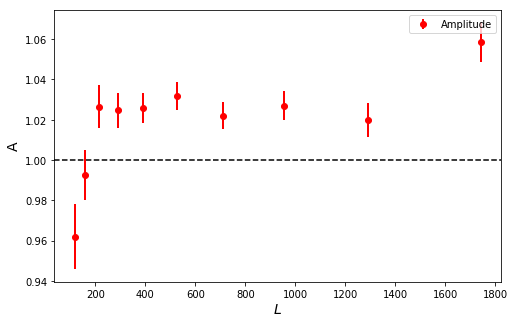

In [29]:
pl.figure(figsize=(8,5))
pl.axhline(y=1.0, ls='--', color='k')

# Plot our amplitude A
# Standard errors
pl.errorbar(bin_centers, A_avg_all, yerr=amplitude_std_all/np.sqrt(len(par.mc_sims_var)),
            color='r', marker='o', markerfacecolor='r',
            ls='None', linewidth=2, capthick=2, zorder=5, label='Amplitude',
           )
pl.legend()
pl.ylabel('A', fontsize=14)
pl.xlabel(r'$L$',fontsize=14)
pl.show()

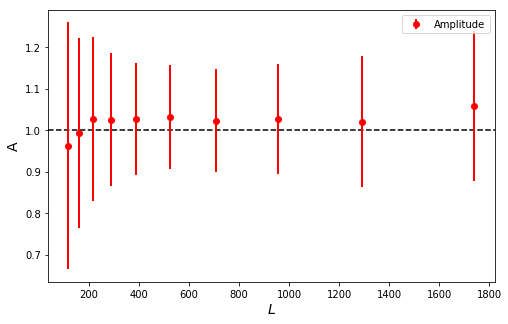

In [30]:
pl.figure(figsize=(8,5))
pl.axhline(y=1.0, ls='--', color='k')

# Plot our amplitude A
# Measurement errors
pl.errorbar(bin_centers, A_avg_all, yerr=amplitude_std_all,
            color='r', marker='o', markerfacecolor='r',
            ls='None', linewidth=2, capthick=2, zorder=5, label='Amplitude',
           )
pl.legend()
pl.ylabel('A', fontsize=14)
pl.xlabel(r'$L$',fontsize=14)
pl.show()